In [1]:
import numpy as np
import pandas as pd

import fiona
import rasterio

from shapely import geometry
from rasterio.mask import mask

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
%matplotlib notebook

In [323]:
%matplotlib inline

In [3]:
BANDS = [461, 480, 490, 502, 516, 526, 540, 554, 555, 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

BANDS_L = [461, 480, 490, 502, 516, 526, 540, 554, ' ', 565, 578, 591, 600, 612, 622, # VIS
         671, 680, 707, 720, 733, 744, 758, 770, 783, 795, 815, 825, 836, 847, 857, 867, 877] # NIR

Almost all firs are located in test polygon $pp_2$ (41 out of 44).

In [4]:
hsi_pp_2 = rasterio.open("../data/pp_2/pp_2_hsi_clipped.tif")

trees_pp_2 = fiona.open("../data/pp_2/pp_2_trees_h/", "r")

In [5]:
def exclude_bad_pixels(image_instance):
    bad_pixels = np.where(image_instance[-1]==0)
    mask = (np.repeat(range(32), bad_pixels[0].shape[0]), 
            np.tile(bad_pixels[0], 32), 
            np.tile(bad_pixels[1], 32))
    image_instance[mask] = np.ma.masked
    

def get_trees(hsi_pp, trees_pp, hsi_radius=1.0):
    hsi_images, labels, ids = [], [], []
    map_tree_speices = {'е':0, 'б':1, 'п':2, "El'":0, "Bereza":1, "Pichta":2, "Sosna":3} 
    
    for tree in trees_pp.values():
        tree_specie = tree['properties']['specie']
        labels.append(map_tree_speices[tree_specie])
        ids.append(tree['properties']['id_tree'])
        
        geometry_hsi = geometry.shape(tree['geometry']).buffer(hsi_radius)
        hsi_image, _ = mask(hsi_pp, [geometry_hsi], filled=False, crop=True)
        
        exclude_bad_pixels(hsi_image)
        hsi_images.append(hsi_image/65535)
    
    return hsi_images, labels, ids

In [6]:
RADIUS_HSI = 1.0

tree_images_pp_2, tree_labels_pp_2, tree_ids_pp_2 = get_trees(hsi_pp_2, trees_pp_2, hsi_radius=RADIUS_HSI)

In [7]:
tree_labels_pp_2 = np.array(tree_labels_pp_2)

tree_ids_pp_2 = np.array(tree_ids_pp_2)

<IPython.core.display.Javascript object>


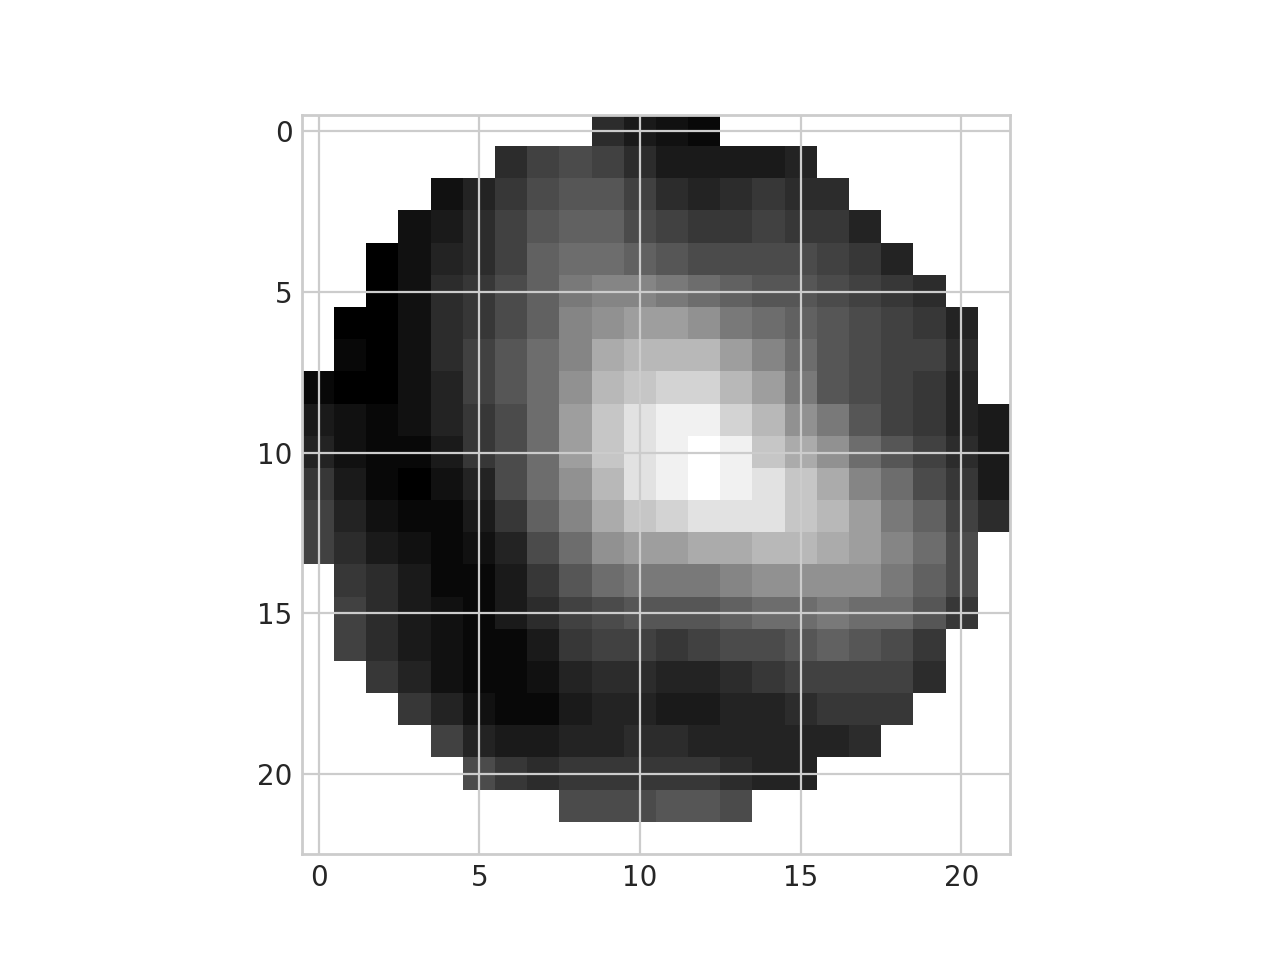

In [59]:
plt.imshow(tree_images_pp_2[273][0], cmap='gray')
plt.show()

In [8]:
def calculate_features(trees_images):
    mean_spectras, median_spectras = [], []
    mean_spectras_norm, median_spectras_norm = [], []
    
    for tree_image in trees_images:
        mean_spectra = [np.ma.mean(band) for band in tree_image]
        median_spectra = [np.ma.median(band) for band in tree_image]
        
        tree_image = tree_image/np.ma.sum(tree_image,axis=0)
        
        mean_spectra_norm = [np.ma.mean(band) for band in tree_image]
        median_spectra_norm = [np.ma.median(band) for band in tree_image]
        
        mean_spectras.append(mean_spectra)
        median_spectras.append(median_spectra)
        
        mean_spectras_norm.append(mean_spectra_norm)
        median_spectras_norm.append(median_spectra_norm)
    
    return (np.array(mean_spectras), np.array(median_spectras),
            np.array(mean_spectras_norm), np.array(median_spectras_norm))

In [9]:
(mean_spectra_pp_2, median_spectra_pp_2,
 mean_spectra_norm_pp_2, median_spectra_norm_pp_2) = calculate_features(tree_images_pp_2)

We take mean normalized spectral values as features for all labeled trees in test polygon $pp_2$ (spruces, birches and firs)

In [10]:
spruces_pp_2 = mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==0)]

birches_pp_2 = mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==1)]

firs_pp_2 = mean_spectra_norm_pp_2[np.where(tree_labels_pp_2==2)]

In [11]:
print('Spruces in pp_2:\t', len(spruces_pp_2))
print('Birches in pp_2:\t', len(birches_pp_2))
print('Firs in pp_2:\t\t', len(firs_pp_2))

Spruces in pp_2:	 242
Birches in pp_2:	 188
Firs in pp_2:		 41


Below there is the plot representing mean features and their standard deviations for all three species. On average, firs and birches have smaller spectral values than spruces in visible range, but in near-infrared range firs have bigger spcetral values than spruces for all bands, whereas birches spectral values are the maximums in 707-783 nm bands and the minimums starting from 825 nm bands.

<IPython.core.display.Javascript object>


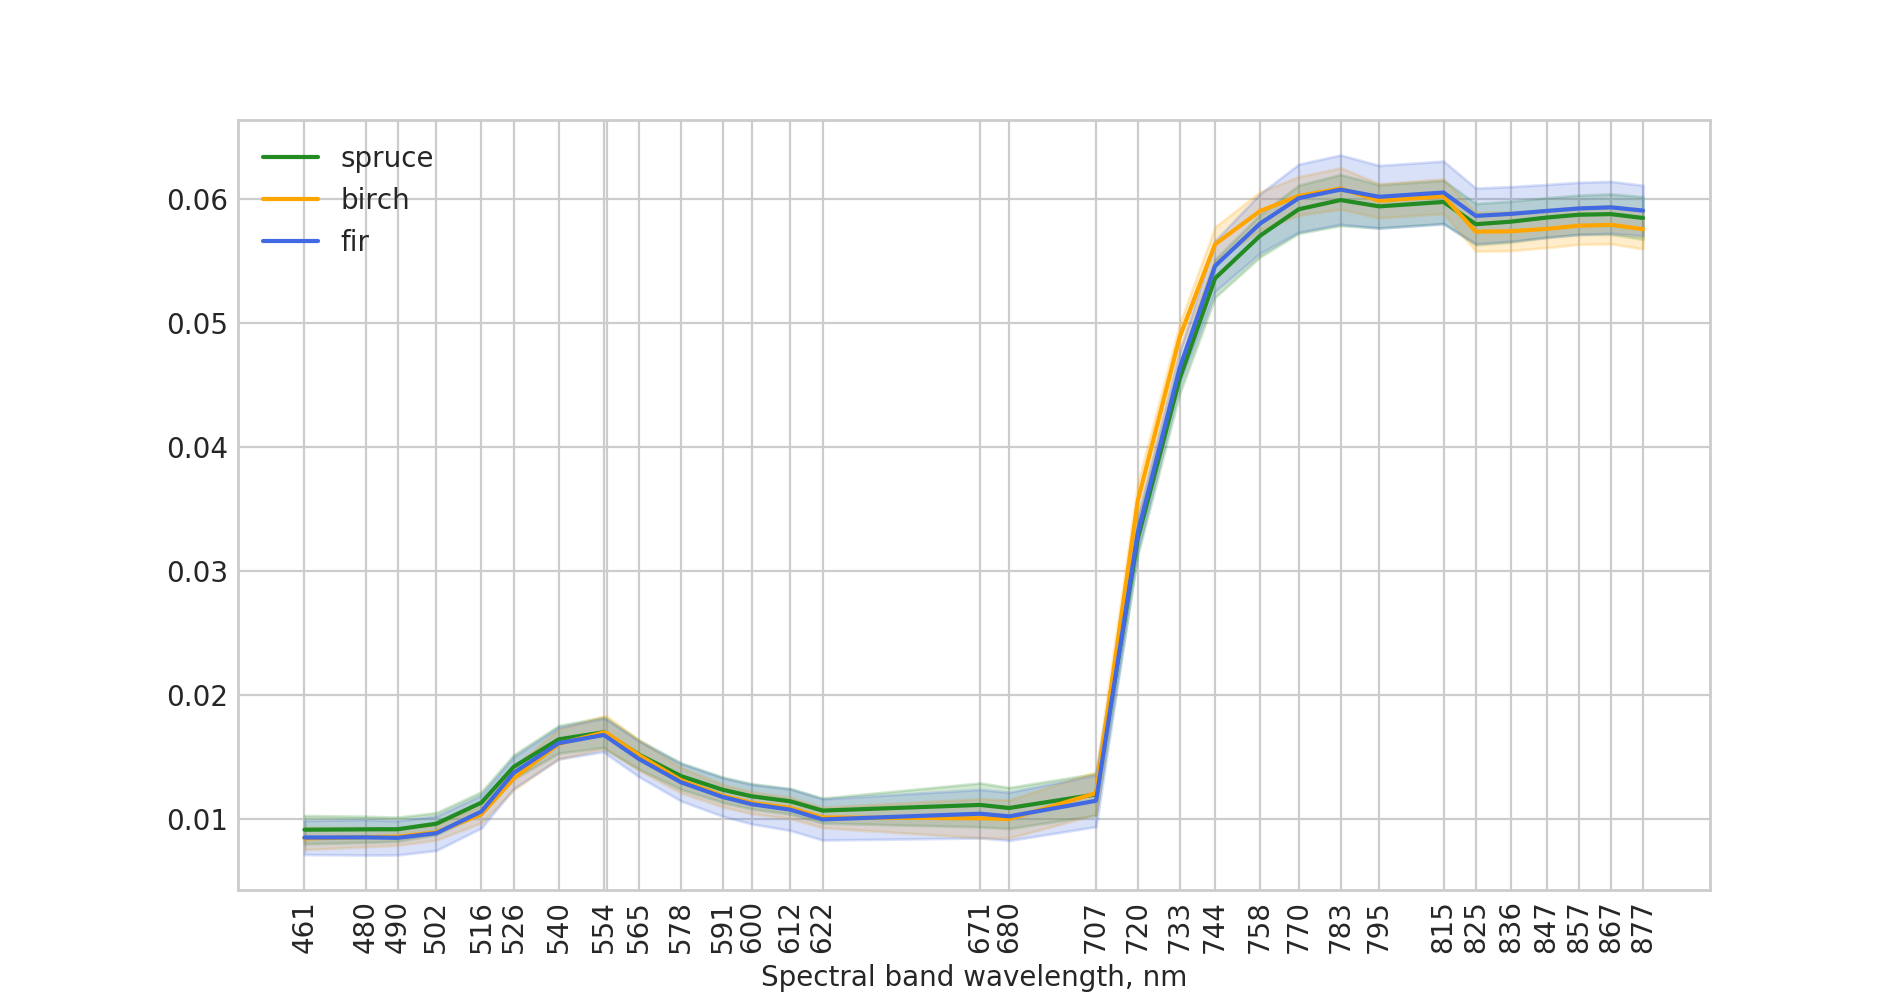

In [16]:
plt.figure(figsize=(9.5,5))
plt.plot(BANDS, np.mean(spruces_pp_2, axis=0), c='forestgreen', label='spruce')
plt.fill_between(BANDS, np.mean(spruces_pp_2, axis=0)+np.std(spruces_pp_2, axis=0),
                 np.mean(spruces_pp_2, axis=0)-np.std(spruces_pp_2, axis=0), color='forestgreen', alpha=0.2)
plt.plot(BANDS, np.mean(birches_pp_2, axis=0), c='orange', label='birch')
plt.fill_between(BANDS, np.mean(birches_pp_2, axis=0)+np.std(birches_pp_2, axis=0),
                 np.mean(birches_pp_2, axis=0)-np.std(birches_pp_2, axis=0), color='orange', alpha=0.2)
plt.plot(BANDS, np.mean(firs_pp_2, axis=0), c='royalblue', label='fir')
plt.fill_between(BANDS, np.mean(firs_pp_2, axis=0)+np.std(firs_pp_2, axis=0),
                 np.mean(firs_pp_2, axis=0)-np.std(firs_pp_2, axis=0), color='royalblue', alpha=0.2)
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Spectral band wavelength, nm')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


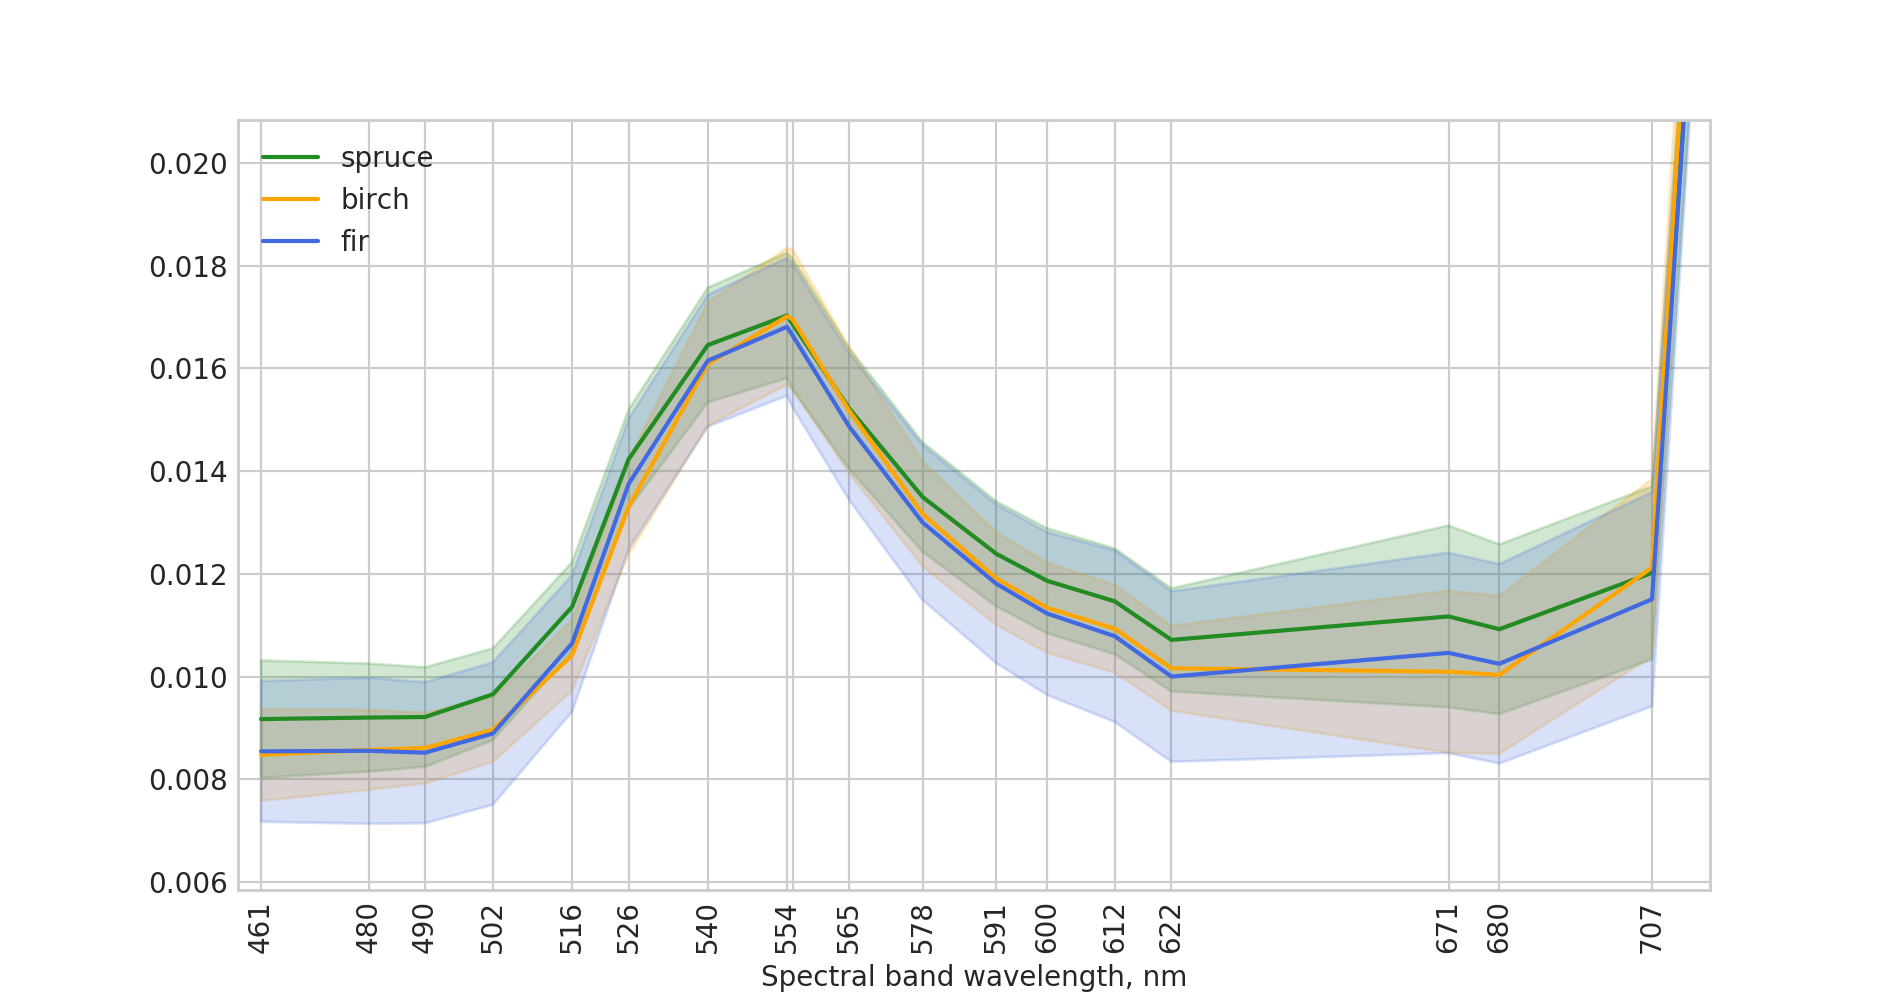

In [14]:
plt.figure(figsize=(9.5,5))
plt.plot(BANDS, np.mean(spruces_pp_2, axis=0), c='forestgreen', label='spruce')
plt.fill_between(BANDS, np.mean(spruces_pp_2, axis=0)+np.std(spruces_pp_2, axis=0),
                 np.mean(spruces_pp_2, axis=0)-np.std(spruces_pp_2, axis=0), color='forestgreen', alpha=0.2)
plt.plot(BANDS, np.mean(birches_pp_2, axis=0), c='orange', label='birch')
plt.fill_between(BANDS, np.mean(birches_pp_2, axis=0)+np.std(birches_pp_2, axis=0),
                 np.mean(birches_pp_2, axis=0)-np.std(birches_pp_2, axis=0), color='orange', alpha=0.2)
plt.plot(BANDS, np.mean(firs_pp_2, axis=0), c='royalblue', label='fir')
plt.fill_between(BANDS, np.mean(firs_pp_2, axis=0)+np.std(firs_pp_2, axis=0),
                 np.mean(firs_pp_2, axis=0)-np.std(firs_pp_2, axis=0), color='royalblue', alpha=0.2)
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Spectral band wavelength, nm')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


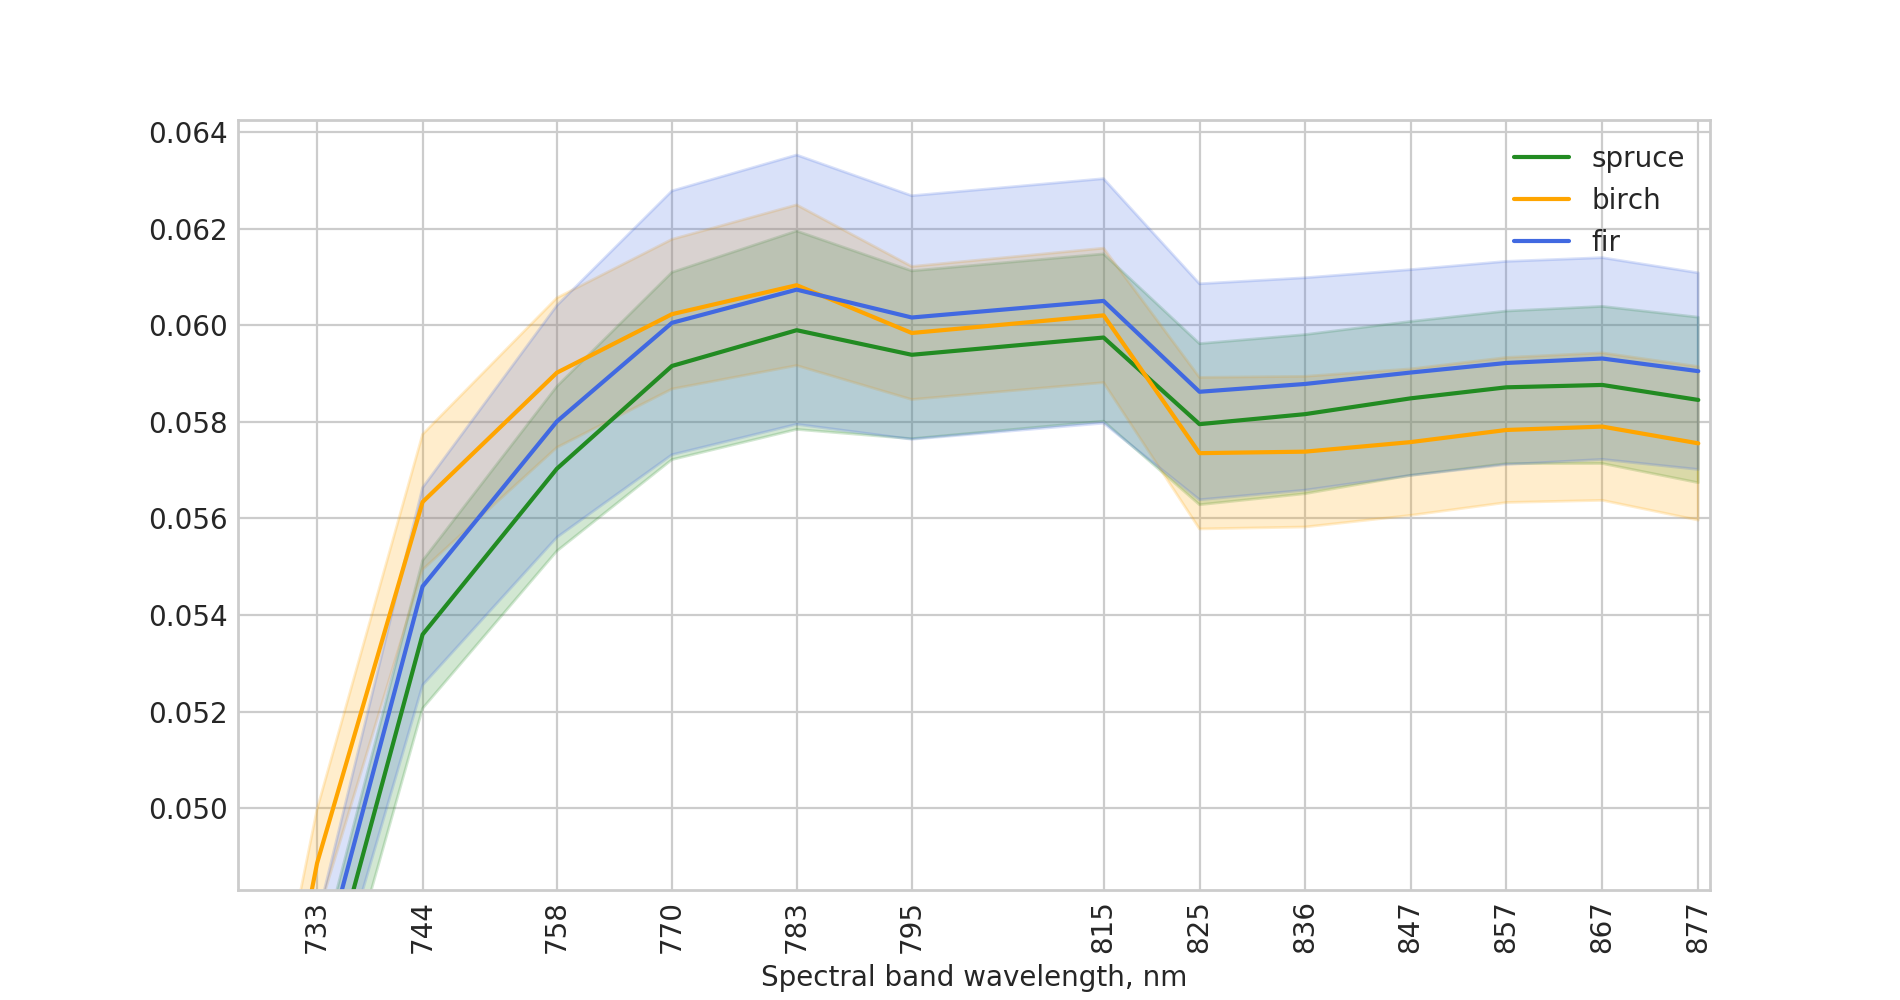

In [15]:
plt.figure(figsize=(9.5,5))
plt.plot(BANDS, np.mean(spruces_pp_2, axis=0), c='forestgreen', label='spruce')
plt.fill_between(BANDS, np.mean(spruces_pp_2, axis=0)+np.std(spruces_pp_2, axis=0),
                 np.mean(spruces_pp_2, axis=0)-np.std(spruces_pp_2, axis=0), color='forestgreen', alpha=0.2)
plt.plot(BANDS, np.mean(birches_pp_2, axis=0), c='orange', label='birch')
plt.fill_between(BANDS, np.mean(birches_pp_2, axis=0)+np.std(birches_pp_2, axis=0),
                 np.mean(birches_pp_2, axis=0)-np.std(birches_pp_2, axis=0), color='orange', alpha=0.2)
plt.plot(BANDS, np.mean(firs_pp_2, axis=0), c='royalblue', label='fir')
plt.fill_between(BANDS, np.mean(firs_pp_2, axis=0)+np.std(firs_pp_2, axis=0),
                 np.mean(firs_pp_2, axis=0)-np.std(firs_pp_2, axis=0), color='royalblue', alpha=0.2)
plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Spectral band wavelength, nm')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


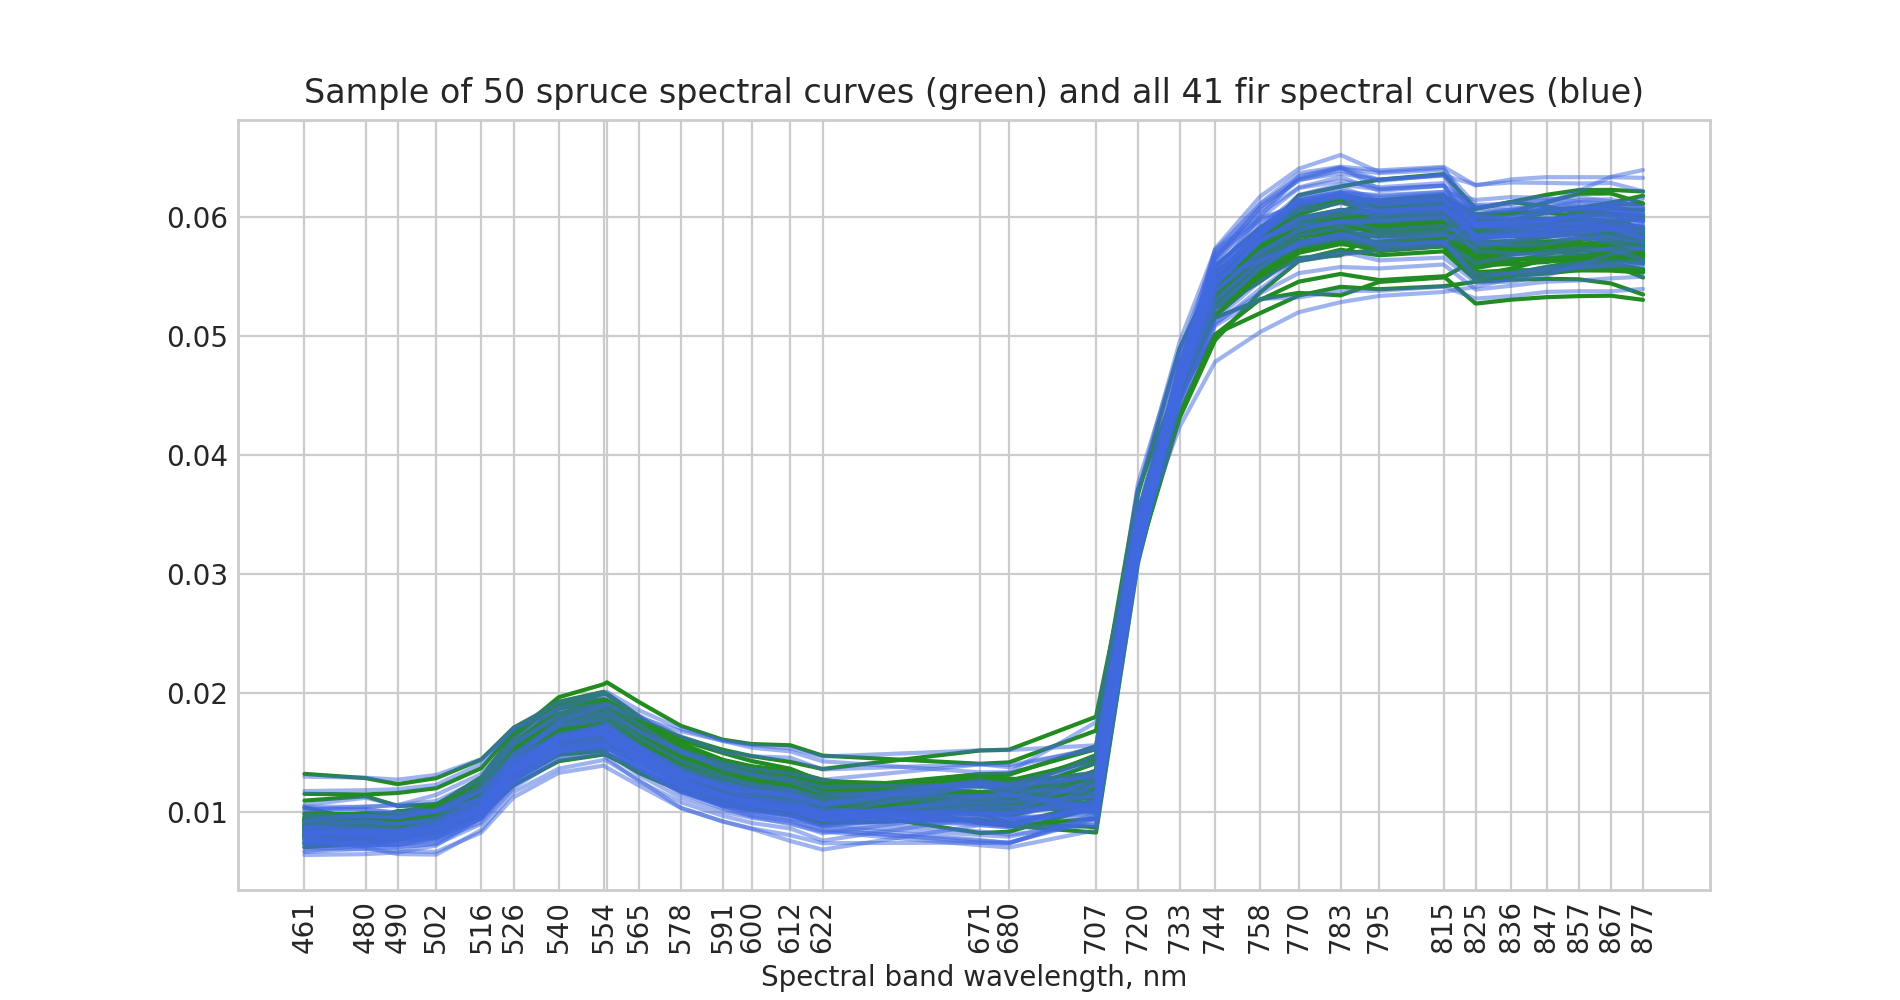

In [75]:
plt.figure(figsize=(9.5,5))

for spruce in spruces_pp_2[:50]:
    plt.plot(BANDS, spruce, c='forestgreen', label='spruce', alpha=1)
    
# for birch in birches_pp_2[:50]:
#     plt.plot(BANDS, birch, c='orange', label='birch', alpha=0.5)

for fir in firs_pp_2:
    plt.plot(BANDS, fir, c='royalblue', label='fir', alpha=0.5)

plt.xticks(BANDS, labels=BANDS_L, rotation='vertical')
plt.xlabel('Spectral band wavelength, nm')
plt.title('Sample of 50 spruce spectral curves (green) and all 41 fir spectral curves (blue)')
plt.show()

## Data Tables

### All Firs (41 trees, pp_2)

In [84]:
firs_table = pd.DataFrame(firs_pp_2, columns=BANDS)

In [86]:
firs_table.to_csv('~/Desktop/firs.csv')

In [85]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(firs_table)

         461       480       490       502       516       526       540  \
0   0.006677  0.006961  0.007050  0.007423  0.009532  0.013119  0.016009   
1   0.007572  0.007475  0.007707  0.007875  0.009595  0.012746  0.015125   
2   0.007482  0.007343  0.007299  0.007821  0.009584  0.012563  0.015047   
3   0.013008  0.012920  0.012754  0.013155  0.014482  0.016972  0.018633   
4   0.007550  0.007853  0.008056  0.008651  0.010614  0.013813  0.016283   
5   0.008572  0.008536  0.008470  0.009084  0.010906  0.014281  0.017656   
6   0.010238  0.010503  0.010624  0.011485  0.013232  0.016221  0.018837   
7   0.007772  0.007984  0.007897  0.008308  0.010320  0.013611  0.015915   
8   0.007664  0.007505  0.007605  0.007948  0.009509  0.012422  0.014889   
9   0.006756  0.007228  0.007361  0.007884  0.009911  0.013458  0.016208   
10  0.007049  0.006908  0.006755  0.006698  0.008325  0.011276  0.013327   
11  0.007944  0.007039  0.006506  0.006462  0.008544  0.011711  0.013675   
12  0.008474

### Sample Spruces (50 trees, pp_2)

In [87]:
spruces_table = pd.DataFrame(spruces_pp_2[:50], columns=BANDS)

In [91]:
spruces_table.to_csv('~/Desktop/spruces.csv')

In [88]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(spruces_table)

         461       480       490       502       516       526       540  \
0   0.010994  0.011368  0.010540  0.010703  0.012064  0.013809  0.015979   
1   0.008136  0.008046  0.007799  0.008216  0.009808  0.012298  0.014306   
2   0.009509  0.009956  0.009900  0.010614  0.012658  0.015880  0.018696   
3   0.008207  0.008311  0.008413  0.009087  0.011312  0.015021  0.017791   
4   0.008215  0.008076  0.008231  0.008621  0.010217  0.013113  0.015312   
5   0.009882  0.009848  0.009807  0.010513  0.012266  0.015160  0.017494   
6   0.007078  0.007406  0.007716  0.008235  0.010170  0.013344  0.015646   
7   0.009007  0.009247  0.009327  0.009870  0.011911  0.014856  0.017339   
8   0.009323  0.009367  0.009198  0.009278  0.010528  0.013294  0.015896   
9   0.007927  0.007789  0.008088  0.008521  0.010425  0.013717  0.016176   
10  0.008038  0.008431  0.008562  0.008986  0.010723  0.013742  0.016160   
11  0.008809  0.009695  0.009722  0.010649  0.012966  0.016543  0.019670   
12  0.008204

# USGS Spectral Library